<img src="https://miro.medium.com/max/1898/1*w4TIZ1VIu7J2FltbyZ6bYA.png" align='left' />

# Desafio 2 - [Competição Titanic](https://www.kaggle.com/c/titanic/overview)

Nesse desafio vamos trabalhar com uma competição do Kaggle pela primeira vez. O objetivo da competição é criar um modelo que consiga prever quais passageiros morreram e quais sobreviveram no acidente do Titanic.

A comunidade do Kaggle disponibiliza os notebooks com possíveis soluções para a competição. É uma fonte super rica de aprendizado entender as ideias que outras pessoas tiveram e ver as aplicações dessas ideias. Não hesitem em consultar! (Só não vale copiar a solução das pessoas na íntegra hehe)

Abaixo deixamos um passo-a-passo dos macro blocos para nortear vocês! Esse Desafio é uma ótima oportunidade para juntarmos os bloquinhos de Lego e vermos as aplicações de boa parte das técnicas e conceitos vistos até agora! Bora lá!

# 1. Importar libs e carregar os DataFrames

Nas competições do Kaggle é comum recebermos 2 DataFrames. Um de treino e um de teste. Neste caso o DataFrame de **teste** é utilizado apenas para gerar o Score do modelo na competição. Nós realizamos todas as etapas no DataFrame de treino e utilizamos o teste apenas para submeter a solução.

In [1]:
### Libs

# Data manipulation
import pandas as pd
import numpy as np

# Data prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
#from category_encoders import TargetEncoder
#from sklearn import preprocessing

# Stats
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
import scipy
from scipy import stats
from sklearn.feature_selection import f_classif, chi2
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, roc_auc_score
# from sklearn.feature_selection import RFECV
#from sklearn.metrics import r2_score, mean_squared_error, fbeta_score, classification_report, auc
#from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
#from statsmodels.graphics.gofplots import qqplot

# Confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Models
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.naive_bayes import GaussianNB

# Other
#from pycaret.datasets import get_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
# DataFrames load
df_traintanic = pd.read_csv('train.csv')
df_testanic = pd.read_csv('test.csv')

In [3]:
# Train DF
df_traintanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# Test DF
df_testanic.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
# High level summary
print(f'Train set: {df_traintanic.shape} & Test set: {df_testanic.shape}')

Train set: (891, 12) & Test set: (418, 11)


# 2. Dividir o Dataset de Treino em treino e teste

Conforme vimos nas aulas, antes de começar a trabalhar com os dados, nós separamos uma parte do DataFrame para posterior avaliação do modelo. É importante que o modelo não tenha contato com nenhuma informação deste DataFrame separado para garantir que quando avaliada sobre este DataFrame, a performance do modelo reflita o comportamento do mesmo para dados nunca vistos.

In [6]:
# Train/test split
df_train, df_test = train_test_split(df_traintanic,
                                     train_size=0.8,
                                     #stratify=df_traintanic['Survived'],
                                     random_state=42)

In [7]:
print('The number of samples in the train set is {}.'.format(df_train.shape[0]))

The number of samples in the train set is 712.


In [8]:
print('The number of samples in the test set is {}.'.format(df_test.shape[0]))

The number of samples in the test set is 179.


In [9]:
if df_test.shape[1] == df_test.shape[1]:
    print(f'Both train & test sets have {df_train.shape[1]} columns')
else:
    print(f'Confirm: train set has {df_train.shape[1]} columns and test set has {df_test.shape[1]} columns')

Both train & test sets have 12 columns


# 3. Limpeza de Dados

Agora, vamos verificar a consistência dos dados. Hora de identificar e tratar valores nulos, remover linhas e/ou colunas duplicadas, identificar e remover inconsistências nos valores das variáveis (Ex. se houver Fare negativo, não faz sentido), identificar e remover colunas constantes, quase constantes e com baixa variância. (Uma boa dica é voltar lá no Módulo 0 e revisitar a aula de Limpeza de Dados).

In [10]:
# Create copy of train_df to work on
train_data01 = df_train.copy()

In [11]:
# Data types
# print(df_train.info())
train_data01.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
# Possible inconsistencies
train_data01.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,0.376404,2.330056,29.498846,0.553371,0.379213,32.586276
std,256.731423,0.484824,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
# Ordenar train DF por Age para entender mejor los valores fraccionados
train_data01.sort_values(['Age'],ascending=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
330,331,1,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q
214,215,0,3,"Kiernan, Mr. Philip",male,NaN,1,0,367229,7.7500,NaN,Q
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
121,122,0,3,"Moore, Mr. Leonard Charles",male,NaN,0,0,A4. 54510,8.0500,NaN,S


In [14]:
# Missing values
train_data01.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            140
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         2
dtype: int64

In [15]:
# Proportion of missing values - Age
# print('Percent of missing "Age" records is %.2f%%' %((df_train['Age'].isnull().sum()/df_train.shape[0])*100))
missing_age = round((train_data01['Age'].isnull().sum()/train_data01.shape[0])*100,2)
print(f'Percent of missing "Age" records is {missing_age}%')

Percent of missing "Age" records is 19.66%


In [16]:
# Proportion of missing values - Cabin
# print('Percent of missing "Cabin" records is %.2f%%' %((train_data01['Cabin'].isnull().sum()/train_data01.shape[0])*100))
missing_cabin = round((train_data01['Cabin'].isnull().sum()/train_data01.shape[0])*100,2)
print(f'Percent of missing "Cabin" records is {missing_cabin}%')

Percent of missing "Cabin" records is 77.67%


In [17]:
# Proportion of missing values - Embarked
# print('Percent of missing "Embarked" records is %.2f%%' %((train_data01['Embarked'].isnull().sum()/train_data01.shape[0])*100))
missing_embarked = round((train_data01['Embarked'].isnull().sum()/train_data01.shape[0])*100,2)
print(f'Percent of missing "Embarked" records is {missing_embarked}%')

Percent of missing "Embarked" records is 0.28%


In [18]:
# Duplicate lines
n_dupe_samples = train_data01.shape[0] - train_data01.drop_duplicates().shape[0]
print(f'There are {n_dupe_samples} duplicate lines')

There are 0 duplicate lines


In [19]:
# Duplicate columns
dupe_columns = []
for col1 in train_data01.columns.tolist():
    for col2 in train_data01.columns.tolist():
        if col1 != col2:
            if (train_data01[col1] == train_data01[col2]).all():
                dupe_columns.append([col1, col2])       

if len(dupe_columns) > 0:
    print('Duplicate columns:', dupe_columns)
else:
    print('There are 0 duplicate columns')

There are 0 duplicate columns


In [20]:
# Constant value columns
const_val_columns = []
for col in train_data01.columns.tolist():
    if train_data01[col].nunique() == 1:
        const_val_columns.append(col)

if len(const_val_columns) > 0:
    print('Constant value columns:', const_val_columns)
    train_data01.drop(const_val_columns, axis=1, inplace=True)
else:
    print('There are 0 constant value columns')

There are 0 constant value columns


In [21]:
# Features (columns) with low variance (don’t meaningfully contribute to the model’s predictive capability)
def identify_cols_low_variance(df, low_variance_threshold):
    # Initialize scaler
    scaler = MinMaxScaler()
    # Select only numerical features
    df_numerical = df.select_dtypes(exclude=['object'])
    # Scale variables
    df_scaled = pd.DataFrame(scaler.fit_transform(df_numerical),
                             columns=df_numerical.columns
                            )
    
    low_var_cols1 = []
    for col in df_scaled.columns:
        if df_scaled[col].var() < low_variance_threshold:
            low_var_cols1.append(col)
            
    return low_var_cols1

low_var_cols2 = identify_cols_low_variance(train_data01, low_variance_threshold=0.001)

if len(low_var_cols2) > 0:
    print('Columns with low variance:', low_var_cols2)
    train_data01.drop(low_var_cols2, axis=1, inplace=True)
    
else:
    print('There are 0 columns with low variance')

There are 0 columns with low variance


#### Missing Values - Age

In [22]:
# Creamos un nuevo feature uniendo Sex & Pclass
train_data01['Group'] = train_data01['Sex'] + '-' + train_data01['Pclass'].astype(str)

In [23]:
# Calculamos el promedio de edad para cada elemento de Group y lo guardamos en un diccionario
age_group_map = {}

for group in train_data01['Group'].unique():
    aux = train_data01.loc[train_data01['Group'] == group]
    median_age = aux['Age'].median()
    age_group_map[group] = median_age

In [24]:
# Revisamos los grupos creados (existe una diferencia significativa entre los diferentes grupos)
age_group_map

{'male-1': 41.0,
 'male-2': 30.0,
 'male-3': 26.0,
 'female-3': 22.0,
 'female-2': 28.0,
 'female-1': 35.0}

In [25]:
# Reemplazamos null values en Age con los valores respectivos de age_group_map (promedio de edad por sexo & clase)
cond_age_null = train_data01['Age'].isnull()
train_data01.loc[cond_age_null, 'Age'] = train_data01.loc[cond_age_null,'Group'].map(age_group_map)
train_data01.drop('Group', axis=1, inplace=True)

#### Missing Values - Cabin

In [26]:
# Creamos un nuevo feature Has_Cabin con valores booleanos y eliminamos feature Cabin
train_data01['Has_Cabin'] = np.where(train_data01['Cabin'].isnull(), 0, 1)
train_data01.drop('Cabin', axis=1, inplace=True)

#### Missing values - Embarked

In [27]:
# Encontramos el valor más frecuente en el feature Embarked y lo repetimos en las casos que existe un null value
most_frequent_val_embarked = train_data01['Embarked'].mode().squeeze()
train_data01['Embarked'] = train_data01['Embarked'].fillna(most_frequent_val_embarked)

In [28]:
# Train DF review (post-adjustments)
train_data01.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.500,S,1
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.000,S,0
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.925,S,0


# 4. Análise Exploratória de Dados (EDA)

Hora de conhecer os dados! Entender qual é a variável target, o que cada uma das colunas representa, quais as variáveis qualitativas, quais as variáveis quantitativas, observar as distribuições das variáveis e observar relações das variáveis com o target e entre si. Super válido procurar mais informações sobre o Titanic também (maior entendimento do negócio). Como funcionava a venda de passagens? Como as cabines eram distribuídas no navio?

Qual é o tipo de problema que vamos tentar resolver? É um problema de aprendizado supervisionado ou não supervisionado? Regressão ou Classificação?

In [29]:
# Actual results: 1514 dead & 710 survivors (31.92%)
# In train set: 38.34% of survivors
print(train_data01.groupby('Survived').count()[['PassengerId']])
print(train_data01.loc[train_data01['Survived']==1].groupby('Survived').count()[['PassengerId']] / train_data01['PassengerId'].count())

          PassengerId
Survived             
0                 444
1                 268
          PassengerId
Survived             
1            0.376404


In [30]:
# Separamos target variable, discrete & continuous features (ignoramos PassengerID, Name, Ticket)
target = 'Survived'
disc_cols = ['Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'SibSp', 'Parch']
cont_cols = ['Age', 'Fare']

In [31]:
# Function to create graphs (histograms, barplots & boxplots) for features' relationship to target
def EDA(df, disc_cols, cont_cols, target):
    for col in df.columns:
        if col in disc_cols:
            fig, ax = plt.subplots(1, 2, figsize=(15, 6))
            fig.suptitle(f'Feature {col}', fontsize=15, fontweight='bold', y=1)
            
            sns.countplot(x=col, data=df, ax=ax[0], ec='black')
            ax[0].grid(axis='y')
            ax[0].set_title(f'Distribution of {col}')
            #ax[0].set_xticklabels(df[col], rotation=45, fontsize=8)
            
            sns.barplot(x=col, y=target, data=df, ax=ax[1], ec='black', ci=None)
            ax[1].grid(axis='y')
            ax[1].set_title(f'Positive {target} by {col}')
            #ax[0].set_xticklabels(df[col], rotation=45, fontsize=8)
            plt.show()

        elif col in cont_cols:
            fig, ax = plt.subplots(1, 2, figsize=(15, 6))
            fig.suptitle(f'Feature {col}', fontsize=15, fontweight='bold', y=1)
            
            sns.histplot(x=col, hue=target, data=df, ax=ax[0])
            ax[0].set_title(f'Distribution of {col}')
            
            sns.boxplot(x=target, y=col, data=df, ax=ax[1])
            ax[1].set_title(f'Positive {target} by {col}')
            plt.show()

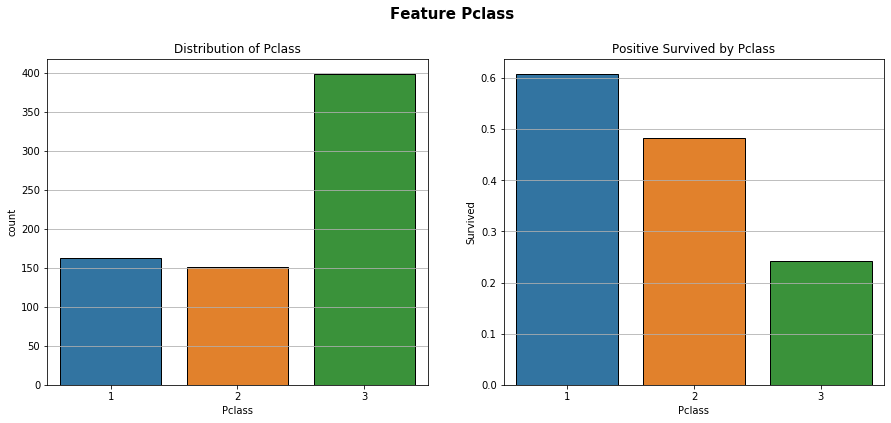

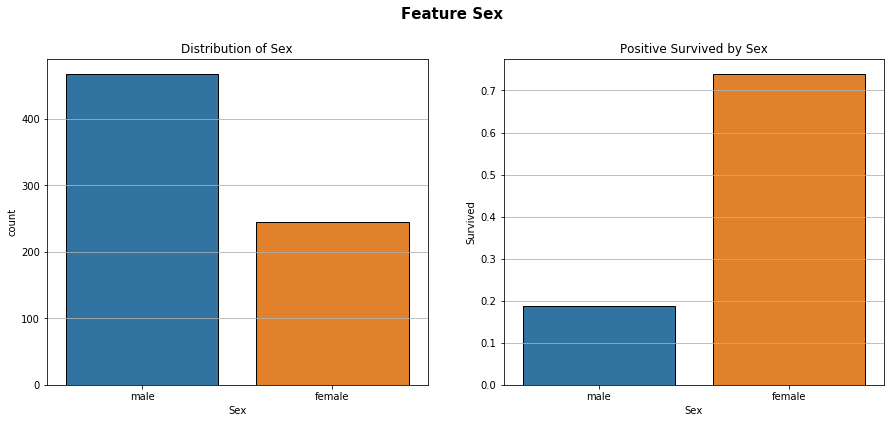

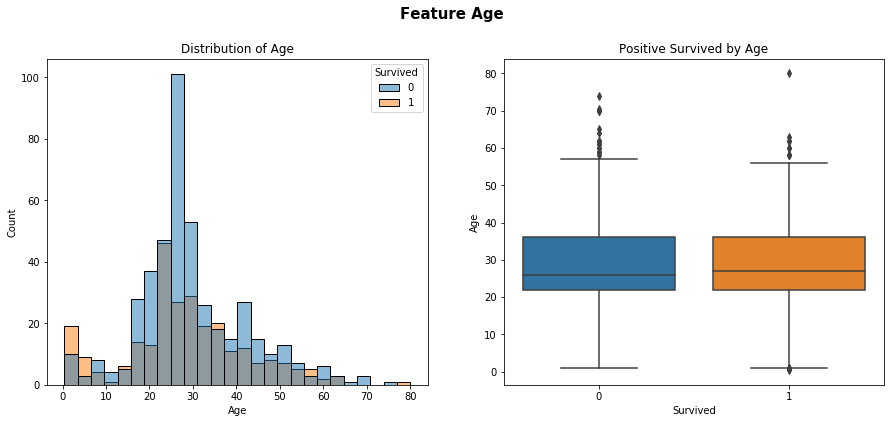

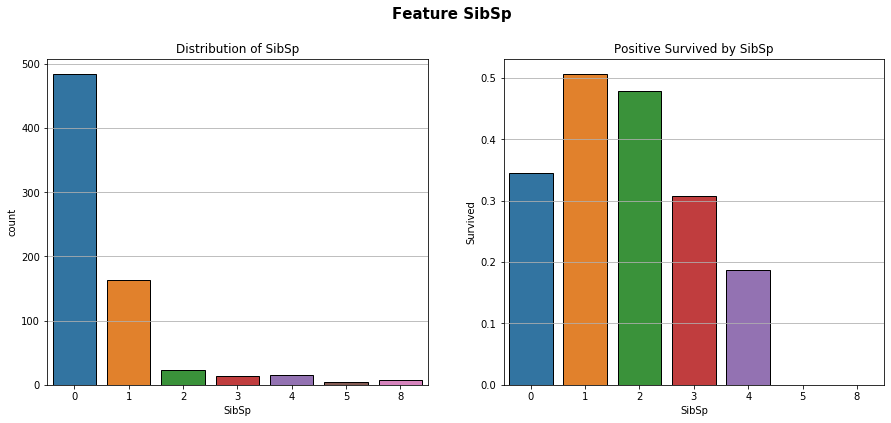

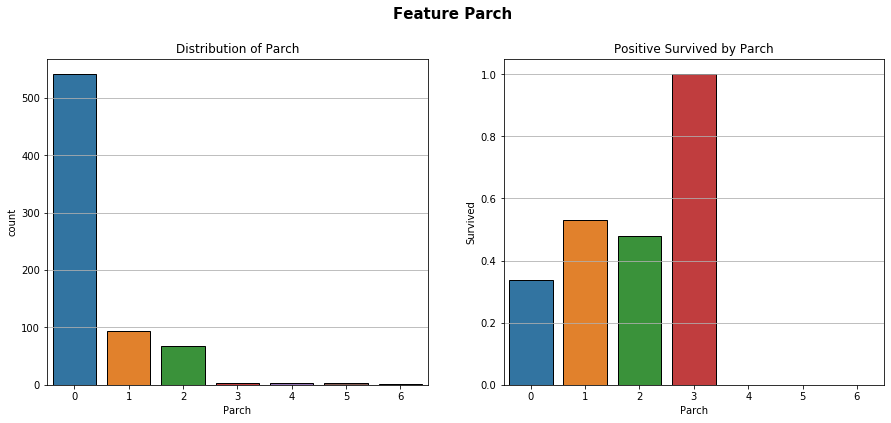

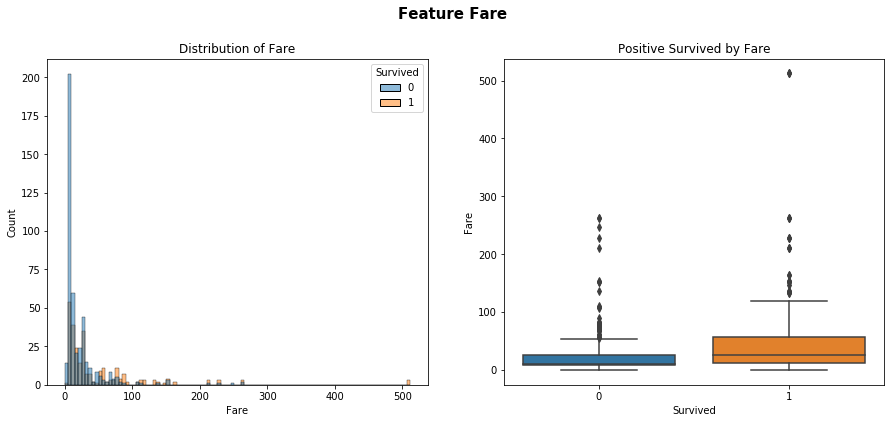

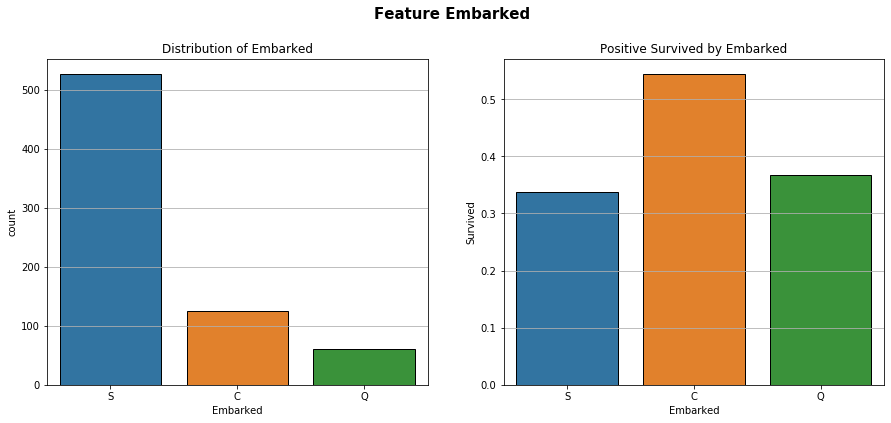

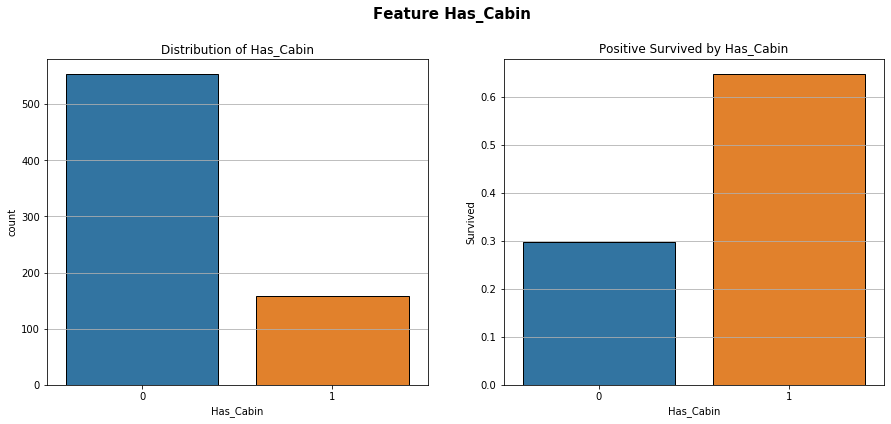

In [32]:
EDA(train_data01, disc_cols, cont_cols, target)

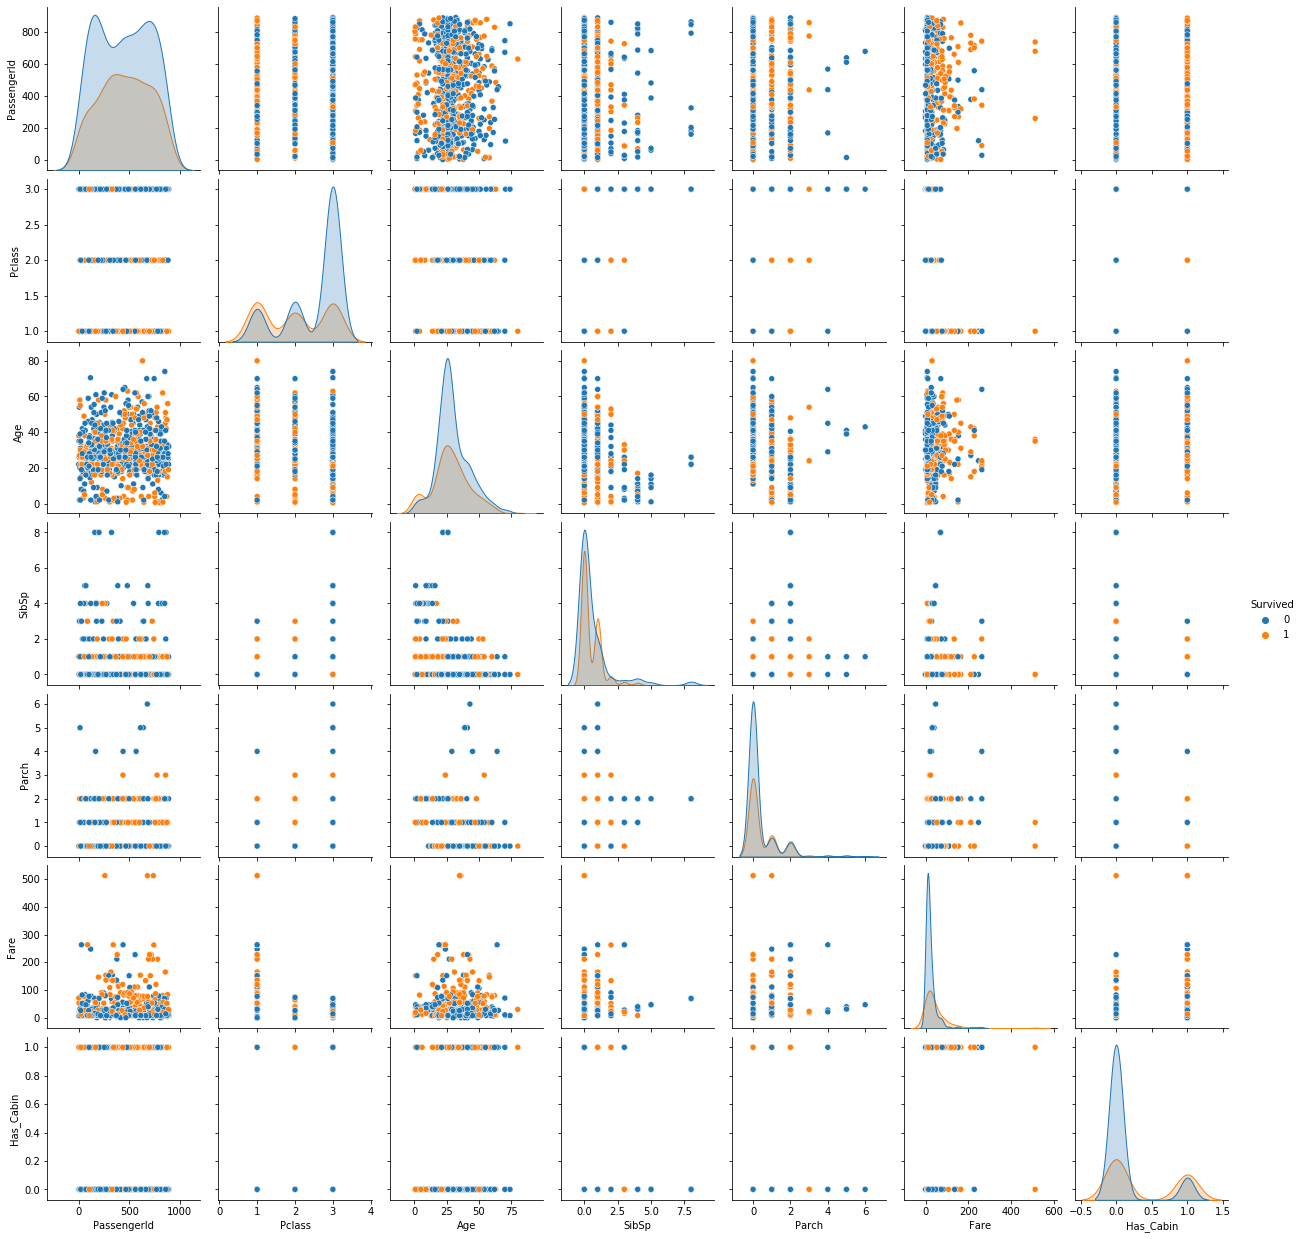

In [33]:
# Creamos pairplots con las variables numéricas
sns.pairplot(data=train_data01,hue=target,diag_kind='kde')
plt.show()

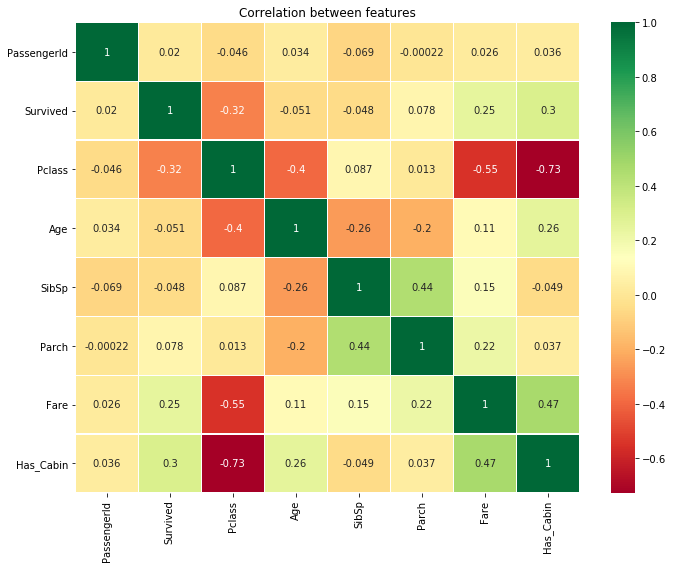

In [34]:
# Correlation matrix
ax = sns.heatmap(train_data01.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Correlation between features')
plt.tight_layout()

# para no cortar primera & última líneas
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [35]:
# Separamos numeric & categorical features (ignoramos PassengerID, Name, Ticket) 
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Embarked', 'Has_Cabin']

In [36]:
# Calculamos la correlación de los features numéricos con el target
# target2 = ['Survived']
train_data01[num_cols+[target]].corr()[target]

Age        -0.050633
SibSp      -0.047602
Parch       0.078311
Fare        0.246641
Survived    1.000000
Name: Survived, dtype: float64

In [37]:
# Calculamos la correlación de los features categóricos con el target (por medio de función Cramer V)
def cramer_v(df, cat_cols):
    df=df
    cat_cols=cat_cols
    # dicionário para guardar o cramer V de cada coluna em relação às demais
    dict_cramer = {}
    # primeiro for loop é para percorrer as colunas categóricas
    for cat in cat_cols:
        # lista para guardar os valores obtidos de cramer v a cada coluna 
        cramer_v_list = []
        # segundo for loop é para percorrer para uma variável categórica todas as colunas do dataframe
        for cat_ in cat_cols:
            # gerando a tabela de contingência
            df_cross = pd.crosstab(df[cat], df[cat_])
            # extraindo o valor de chi2
            chi2_teste, p, df_, arr = stats.chi2_contingency(df_cross)
            # calculando o número de linhas
            r = len(df_cross)
            # calculando o número de colunas
            c = len(df_cross.columns)
            # calculando a soma dos elementos das células
            n = df_cross.to_numpy().sum()
            # calculando o V de cramer
            V = np.sqrt((chi2_teste/(n*(np.min([r,c]) -1))))
            # appendando o resultado na lista
            cramer_v_list.append(V)
        # salvando para um elemento do dicionário a lista contendo os V de cramer correspondentes
        dict_cramer[cat] = cramer_v_list
        # criando dataframe a partir do dicionário
        df_v_cramer = pd.DataFrame(dict_cramer)
        # adicionando o índice com o nome das variáveis
        df_v_cramer.index=cat_cols
    return df_v_cramer

In [38]:
# V de Cramer
cramer_v(train_data01, cat_cols+[target])[target].sort_values()

Embarked     0.160473
Has_Cabin    0.296890
Pclass       0.325434
Sex          0.538699
Survived     0.997008
Name: Survived, dtype: float64

# 5. Feature Engineering

Agora que temos os dados limpos e entendemos um pouco mais do problema de negócio, hora de tentar criar variáveis, a partir das existentes, para aumentar a explicabilidade do modelo. Vale consultar a aba de **Notebooks** da competição, observar ideias que as pessoas tiveram e aplicar elas aqui. Como falamos em aula, não tem uma receita para feature engineering, a experiência conta bastante então é um bom momento para pegarmos umas ideias diferentes.

Deixo algumas ideias aqui: será que o fato de o número da cabine ser nulo têm alguma influência sobre a probabilidade de a pessoa sobreviver ou não? Na variável com o nome do passageiro, temos o título (Mr., Mrs., etc). Será que o título, de alguma forma, contribui para a probabilidade de sobrevivência?

Usem a criatividade e, principalmente, testem várias coisas diferentes!!

In [39]:
# Creamos una columna que nos indique si el pasajero viajaba acompañado a partir de SibSp & Parch
train_data01['Travel_Alone'] = np.where((train_data01['SibSp']+train_data01['Parch'])>0,0,1)

In [40]:
# Creamos una columna para agrupar los valores de Age en 4 grupos
train_data01['Age_Band'], age_bins = pd.cut(train_data01['Age'], 4, retbins=True)
train_data01['Age_Band'].unique()

[(40.21, 60.105], (20.315, 40.21], (0.34, 20.315], (60.105, 80.0]]
Categories (4, interval[float64]): [(0.34, 20.315] < (20.315, 40.21] < (40.21, 60.105] < (60.105, 80.0]]

In [41]:
# Creamos un nuevo feature con los títulos que aparecen en Name, y contamos la cantidad de cada uno de los títulos
train_data01['Title'] = train_data01['Name'].str.extract(' ([A-Za-z]+)\.')
train_data01['Title'].value_counts()

Mr          419
Miss        143
Mrs          96
Master       33
Rev           5
Dr            5
Mlle          2
Col           2
Major         2
Capt          1
Lady          1
Mme           1
Ms            1
Countess      1
Name: Title, dtype: int64

In [42]:
# Reemplazamos los títulos similares a otros por las versiones más comunes
train_data01['Title'] = train_data01['Title'].replace(['Col','Major'], 'Mr')
train_data01['Title'] = train_data01['Title'].replace(['Ms', 'Lady', 'Mlle'], 'Miss')
train_data01['Title'] = train_data01['Title'].replace(['Countess', 'Mme'], 'Mrs')

In [43]:
# Reemplazamos los títulos menos comunes por 'Other'
common_titles = ['Mr', 'Miss', 'Mrs']
train_data01['Title'] = train_data01['Title'].apply(lambda x: x if x in common_titles else 'Other')
train_data01['Title'].value_counts()

Mr       423
Miss     147
Mrs       98
Other     44
Name: Title, dtype: int64

In [44]:
# Revisamos train DF
train_data01.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin,Travel_Alone,Age_Band,Title
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.500,S,1,1,"(40.21, 60.105]",Mr
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.000,S,0,1,"(20.315, 40.21]",Mr
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.925,S,0,1,"(20.315, 40.21]",Mr


In [45]:
# Drop unused features
unused_features = ['PassengerId','Name','Age','SibSp','Parch','Ticket']
train_data01.drop(unused_features, axis=1, inplace=True)
train_data01.head(3)

,Survived,Pclass,Sex,Fare,Embarked,Has_Cabin,Travel_Alone,Age_Band,Title
331,0,1,male,28.500,S,1,1,"(40.21, 60.105]",Mr
733,0,2,male,13.000,S,0,1,"(20.315, 40.21]",Mr
382,0,3,male,7.925,S,0,1,"(20.315, 40.21]",Mr


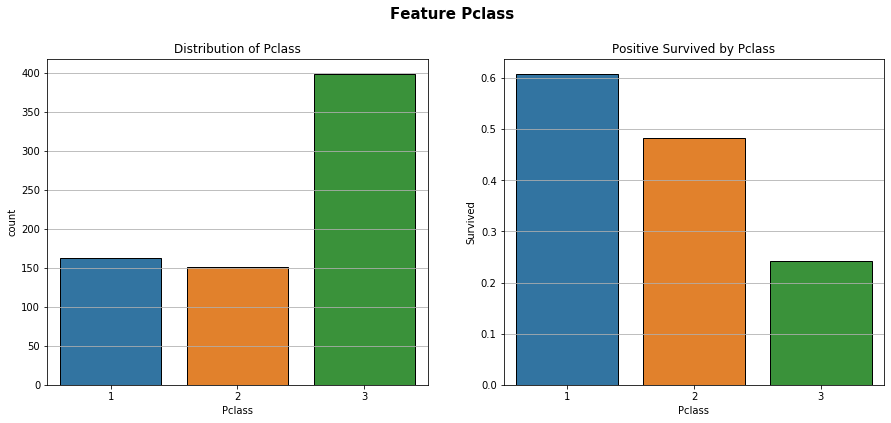

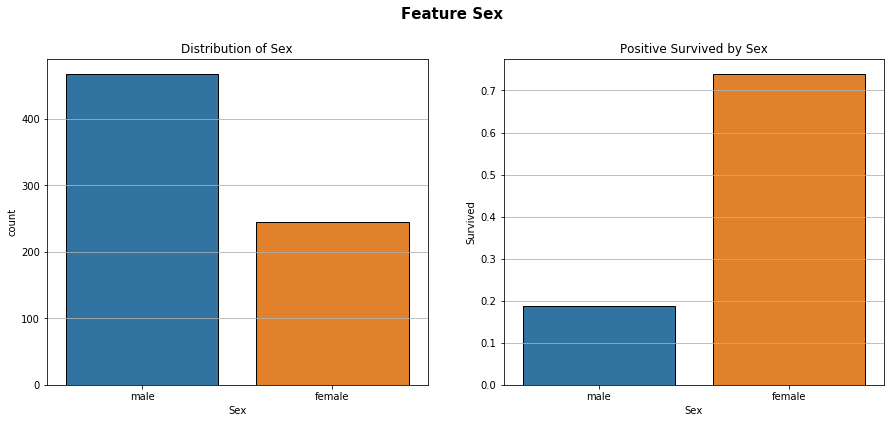

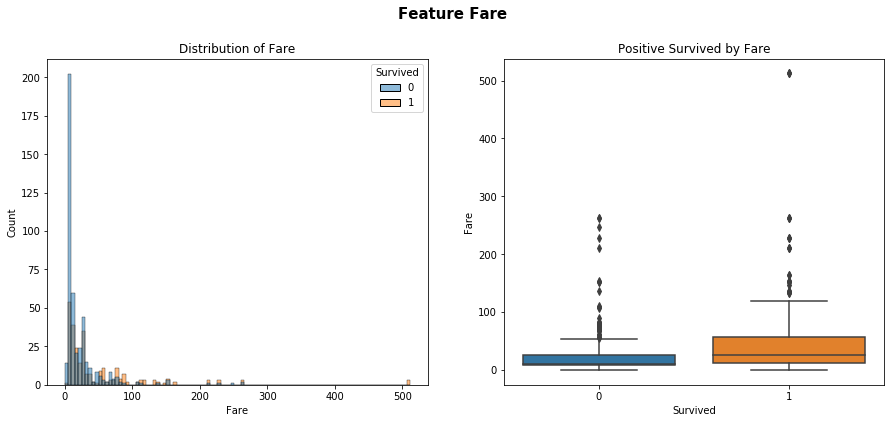

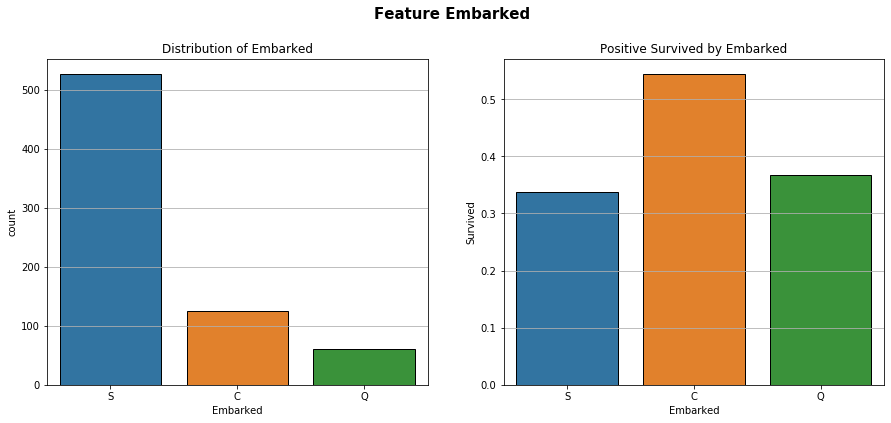

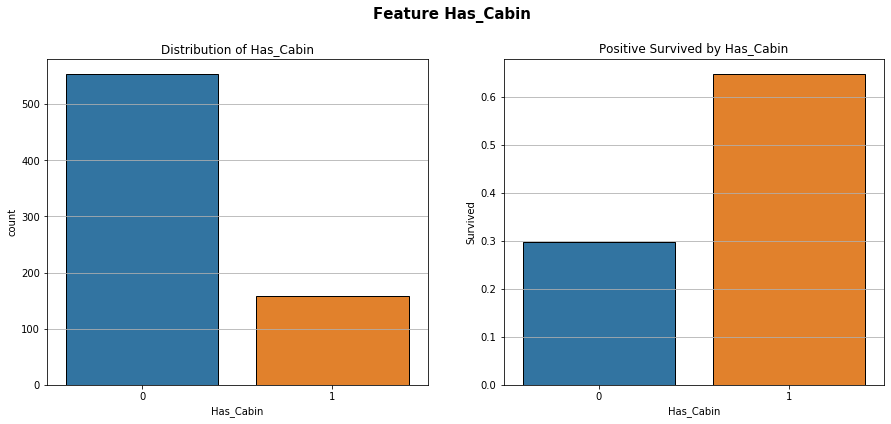

In [46]:
# revisamos nuevamente los remaining features
EDA(train_data01, disc_cols, cont_cols, target)

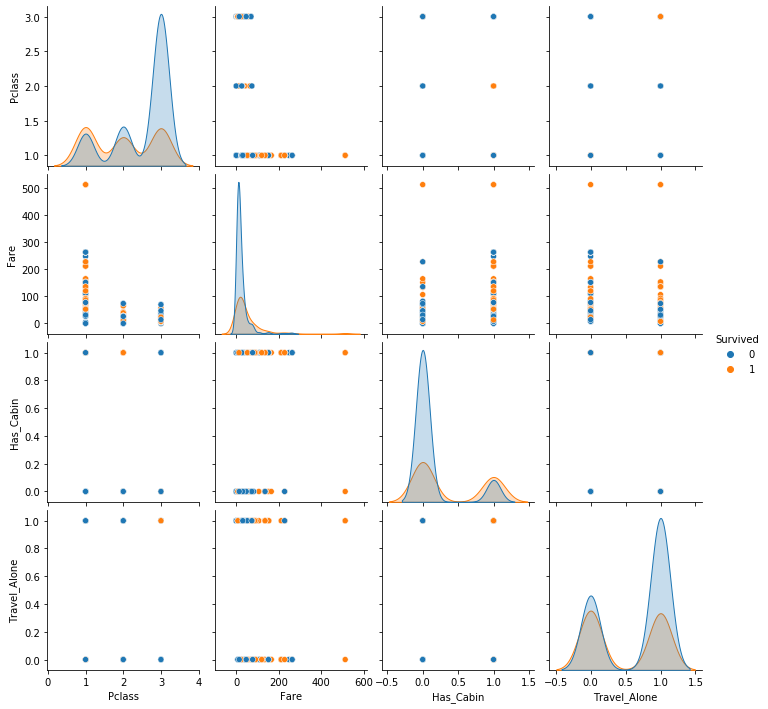

In [47]:
# Creamos pairplots con las variables numéricas restantes
sns.pairplot(data=train_data01,hue=target,diag_kind='kde')
plt.show()

# 6. Feature Selection

De todas as Features que temos, vamos identificar quais, de fato, são relevates para o nosso problema. Faremos isso em duas etapas, como vimos em aula.

### 6.1 Filter Method

Nesta etapa verificamos se as relações observadas entre as variáveis e o target são estatisticamente significativas. Para isso, utilizamos testes de hipótese como ANOVA e chi2. Analisando os p-valores, identificamos variáveis que não são estatisticamente significativas e as removemos do conjunto.

In [48]:
# Split DF into X_train & y_train

# X = df_train_clean.drop('Survived',axis=1)
# y = df_train_clean['Survived']

X_train = train_data01.drop(target,axis=1)
y_train = train_data01[target]

In [49]:
# Data types
# X_train.dtypes
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        712 non-null    int64   
 1   Sex           712 non-null    object  
 2   Fare          712 non-null    float64 
 3   Embarked      712 non-null    object  
 4   Has_Cabin     712 non-null    int64   
 5   Travel_Alone  712 non-null    int64   
 6   Age_Band      712 non-null    category
 7   Title         712 non-null    object  
dtypes: category(1), float64(1), int64(3), object(3)
memory usage: 61.6+ KB
None


In [50]:
# Split X_train into numeric and categorical features
X_train_num = X_train.loc[:,['Fare']] # use ANOVA
X_train_cat = X_train.loc[:,['Pclass','Sex','Embarked','Has_Cabin','Travel_Alone','Age_Band','Title']] # use chi2

#### Numeric Features

In [51]:
# Revisamos num_cols creadas para EDA y actualizamos
num_cols

['Age', 'SibSp', 'Parch', 'Fare']

In [52]:
# Limpiamos num_cols para mantener consistencia
num_cols.remove('Age')    # Age_Band
num_cols.remove('SibSp')  # Travel_Alone
num_cols.remove('Parch')  # Travel_Alone
num_cols

['Fare']

In [53]:
# Hypothesis test using ANOVA
anova_result = f_classif(X_train_num, y_train)
anova_result

(array([45.98802465]), array([2.50643358e-11]))

In [54]:
# Arrange p-values into a series
p_values_num_features = pd.Series(anova_result[1])
p_values_num_features.index = num_cols

# Filter only features with a p-value < 0.05
filter_num_features = p_values_num_features[p_values_num_features < 0.05].index.tolist()
filter_num_features

['Fare']

In [55]:
# ANOVA results
p_values_num_features

Fare    2.506434e-11
dtype: float64

#### Categorical Features

In [56]:
# Revisamos cat_cols creadas para EDA y actualizamos
cat_cols

['Pclass', 'Sex', 'Embarked', 'Has_Cabin']

In [57]:
# Limpiamos cat_cols para mantener consistencia
cat_cols.extend(['Travel_Alone','Age_Band','Title'])
cat_cols

['Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'Travel_Alone', 'Age_Band', 'Title']

In [58]:
# Hypothesis test using chi2
p_values_cat_features = {}
for col in cat_cols:
    # Create a contingency table (crosstab)
    df_cross = pd.crosstab(train_data01[col], train_data01['Survived'])
    # Apply chi2 test & extract p-value
    p_value = stats.chi2_contingency(df_cross)[1]
    # Store features & their p-values into a dictionary
    p_values_cat_features[col] = p_value

In [59]:
# Arrange p-values and columns into a series
p_values_cat_features = pd.Series(p_values_cat_features)

# Filter only features with a p-value < 0.05
filter_cat_features = p_values_cat_features[p_values_cat_features < 0.05].index.tolist()
filter_cat_features

['Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'Travel_Alone', 'Title']

In [60]:
# chi2 results
p_values_cat_features

Pclass          4.224782e-17
Sex             7.503669e-47
Embarked        1.043689e-04
Has_Cabin       2.336744e-15
Travel_Alone    2.153735e-06
Age_Band        4.736588e-01
Title           1.058744e-49
dtype: float64

In [61]:
# Unify features (Numeric + categorical) selected using Filter Method
features_filter = filter_num_features + filter_cat_features
features_filter

['Fare', 'Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'Travel_Alone', 'Title']

### 6.2 Wrapper Method

Aqui utilizamos alguns algoritmos como Boruta ou RFE, cuja ideia é identificar quais as variáveis que, de fato contribuem para o modelo. Tais algoritmos fazem isso, por exemplo, testando a feature contra uma versão randomizada de si mesma ou avaliando se um modelo com a feature performa signficativamente melhor do que o mesmo modelo sem a feature em questão.

In [62]:
# Convertimos los features categóricos en object para su uso en el modelo Boruta
for col in cat_cols:
    X_train[col] = X_train[col].astype('object')

In [63]:
# Initialize Frequency Encoder for categorical features (other encoders also possible) and apply transformation to X_train
freq_enc = CountFrequencyEncoder(encoding_method='frequency',variables=cat_cols)
X_train_encoded = freq_enc.fit_transform(X_train)

In [64]:
# Initialize Random Forest for use in Boruta
forest = RandomForestClassifier(n_jobs=-1, max_depth=5)
# Initialize Boruta feature selection library
boruta_selector = BorutaPy(forest, n_estimators=50, max_iter=100, random_state=42)
# Adjust Boruta on train data
boruta_selector.fit(np.array(X_train_encoded), y_train)

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=50,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FD46DC89050),
         n_estimators=50, random_state=RandomState(MT19937) at 0x7FD46DC89050)

In [65]:
# View significant features
boruta_selector.support_

array([ True,  True,  True, False, False, False, False,  True])

In [66]:
# View features with questionable significance
boruta_selector.support_weak_

array([False, False, False, False, False, False, False, False])

In [67]:
# Collect names of significant features
features_boruta = X_train_encoded.loc[:, boruta_selector.support_].columns.tolist()
features_boruta

['Pclass', 'Sex', 'Fare', 'Title']

In [68]:
# Filter features selected by both Filter & Wrapper Method
selected_features = list(set(features_boruta).intersection(set(features_filter)))
selected_features

['Pclass', 'Sex', 'Title', 'Fare']

In [69]:
# Filter X_train for the selected features
X_train = X_train[selected_features]
X_train.head(3)

,Pclass,Sex,Title,Fare
331,1,male,Mr,28.500
733,2,male,Mr,13.000
382,3,male,Mr,7.925


In [70]:
# Atualiza variáveis categóricas e numéricas
cat_cols_updated = ['Sex', 'Pclass', 'Title']
num_cols_updated = ['Fare']

# 7. Data Prep

Tendo em mãos as variáveis selecionadas, hora de pré processar esses dados para entrar no modelo. Hora de começar nosso Pipeline criando um Column Transformer para fazer encoding das variáveis categóricas e Scaling das variáveis numéricas. Qual encoder e qual Scaler usar fica por conta de vocês :)

In [71]:
# Define scaling for numeric features (robust scaler is ideal due to outliers in feature)
pipe_num_features = ('robust_scaler',
                     RobustScaler(),
                     num_cols_updated
                    )

In [72]:
# Define encoding for categorical features
pipe_cat_features = ('freq_encoder',
                     CountFrequencyEncoder(encoding_method='frequency',variables=cat_cols_updated),
                     cat_cols_updated
                    )

In [73]:
# Use ColumnTransformer to apply data transformations to different columns in dataset
transformers = [pipe_cat_features, pipe_num_features]
preprocessor = ColumnTransformer(transformers)

# 8. Ajuste do modelo

Features selecionadas, Data Prep estruturado, hora de finalizar a construção do Pipeline com o modelo escolhido. Como trata-se de um problema de **classificação**, em que a variável target é **categórica**, qual modelo utilizamos mesmo? Por enquanto só vimos dois modelos, um para regressão e outro para classificação, mas se quiserem se aventurar em outros modelos, fiquem a vontade para procurar e testar!

Uma vez construído o Pipeline, hora de fazer o fit nos dados de treino!

In [74]:
# Initialize Logistic Regression model
model = LogisticRegression(random_state=42)

In [75]:
# Create Pipeline for preprocessing and defining model
pipe = Pipeline(steps=[('p',preprocessor),
                       ('m',model)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(transformers=[('freq_encoder',
                                                  CountFrequencyEncoder(encoding_method='frequency',
                                                                        variables=['Sex',
                                                                                   'Pclass',
                                                                                   'Title']),
                                                  ['Sex', 'Pclass', 'Title']),
                                                 ('robust_scaler',
                                                  RobustScaler(), ['Fare'])])),
                ('m', LogisticRegression(random_state=42))])

# 9. Avaliação do Modelo e escolha do Threshold

Modelo treinado, agora bora avaliar a performance dele. Hora de fazer um predict nos dados de treino e de teste (que separamos no começo, ainda não chegou a hora de utilizarmos o dataset de teste fornecido pela competição).

A métrica da competição é Accuracy, mas nós vimos outras em aula e vale a pena calcular todas elas (Precision, Recall, F-beta, ROC AUC). Além disso, vale testar diferentes thresholds para ver se alterando o threshold observamos aumento da performance do modelo.

Importante nos atentarmos às métricas de treino e teste. Lembrando que quando o modelo performa muito bem no treino e não tão bem no teste, este é um indicativo de overfitting. O modelo "decorou" os dados de treino, aprendendo, inclusive, o ruído e quando recebe dados nunca vistos, não performa bem. Caso as métricas de treino e teste sejam baixas, isto indica underfitting, ou seja, o modelo não é complexo o suficiente para representar, de forma satisfatória, o problema. Podemos tentar adicionar novas variáveis ou utilizar modelos mais complexos (de maior variância).

In [76]:
# Preliminary train result (Accuracy)
print('Accuracy in train set:', pipe.score(X_train, y_train))

Accuracy in train set: 0.7907303370786517


In [77]:
# Apply all DF adjustments to test set

# test_data01 = df_test.copy()

#test_data01['Group'] = train_data01['Sex'] + '-' + test_data01['Pclass'].astype(str)
#for group in test_data01['Group'].unique():
#    aux = test_data01.loc[test_data01['Group'] == group]
#    median_age = aux['Age'].median()
#    age_group_map[group] = median_age
#cond_age_null = test_data01['Age'].isnull()
#test_data01.loc[cond_age_null, 'Age'] = test_data01.loc[cond_age_null,'Group'].map(age_group_map)
#test_data01.drop('Group', axis=1, inplace=True)

#test_data01['Has_Cabin'] = np.where(test_data01['Cabin'].isnull(), 0, 1)
#test_data01.drop('Cabin', axis=1, inplace=True)

#most_frequent_val_embarked = test_data01['Embarked'].mode().squeeze()
#test_data01['Embarked'] = test_data01['Embarked'].fillna(most_frequent_val_embarked)

#test_data01['Travel_Alone'] = np.where((test_data01['SibSp']+test_data01['Parch'])>0,0,1)

#test_data01['Age_Band'], age_bins = pd.cut(test_data01['Age'], 4, retbins=True)
#age_bins[0] = 0
#age_bins[-1] = 80

df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.')
df_test['Title'] = df_test['Title'].replace(['Col','Major'], 'Mr')
df_test['Title'] = df_test['Title'].replace(['Ms', 'Lady', 'Mlle'], 'Miss')
df_test['Title'] = df_test['Title'].replace(['Countess', 'Mme'], 'Mrs')
#common_titles = ['Mr', 'Miss', 'Mrs']
df_test['Title'] = df_test['Title'].apply(lambda x: x if x in common_titles else 'Other')

unused_features_final = ['PassengerId','Name','Age','SibSp','Parch','Ticket','Cabin','Embarked']
df_test.drop(unused_features_final, axis=1, inplace=True)
df_test.head(3)

,Survived,Pclass,Sex,Fare,Title
709,1,3,male,15.2458,Other
439,0,2,male,10.5000,Mr
840,0,3,male,7.9250,Mr


In [78]:
# Make final feature adjustments to test DF so it matches train DF
# test_data01.drop(['Embarked','Travel_Alone','Age_Band'], axis=1, inplace=True)

# Split DF into X_test & y_test
X_test = df_test.drop('Survived',axis=1)
y_test = df_test['Survived']

In [79]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (712, 4)
y_train shape: (712,)
X_test shape: (179, 4)
y_test shape: (179,)


In [80]:
# Calculate model prediction
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [81]:
# Accuracy: % of passengers correctly classified by the model (TP + TN / TP + FP + FN + TN)
print('Accuracy in train set:', pipe.score(X_train,y_train))
print('Accuracy in test set:', accuracy_score(y_test,y_pred_test))

Accuracy in train set: 0.7907303370786517
Accuracy in test set: 0.776536312849162


In [82]:
# Precision: % of passengers correctly classified by the model as survivors (TP / TP + FP)
print('Precision in train set:', precision_score(y_train, y_pred_train))
print('Precision in test set:', precision_score(y_test, y_pred_test))

Precision in train set: 0.7195571955719557
Precision in test set: 0.7236842105263158


In [83]:
# Recall: % of survivors that were correctly classified by the model (TP / TP + FN)
print('Recall in train set:', recall_score(y_train, y_pred_train))
print('Reest in test set:', recall_score(y_test, y_pred_test))

Recall in train set: 0.7276119402985075
Reest in test set: 0.7432432432432432


In [84]:
# F1 Score: weighted average of Precision and Recall (2 * (Recall * Precision) / (Recall + Precision))
print('F1 score for train set:', f1_score(y_train, y_pred_train))
print('F1 score for test set:', f1_score(y_test, y_pred_test))

F1 score for train set: 0.7235621521335807
F1 score for test set: 0.7333333333333334


In [ ]:
# Confusion matrix
forest = RandomForestRegressor(n_jobs=-1,max_depth=5)
curve_predictions = cross_val_predict(forest,X_train,y_train,cv=3)
confusion_matrix(y_train,y_pred_train)

In [ ]:
# AUC-ROC curve: probability of model classifying
#fpr,tpr,thresholds = roc_curve(y_traina,curve_predictions)
#logit_auc = roc_auc_score(y_train,curve_predictions)

#plt.plot(fpr,tpr,label='logit_auc= %0.4f'%logit_auc)
#plt.plot([0,1],[0,1],'r--')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('ROC Curve')

#plt.show()

In [86]:
# Store probability of survival for each passenger in a variable
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

In [94]:
# calculate roc curve (determine the false positive and true positive rates)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.4f' % auc)

AUC: 0.8625


ROC AUC: 0.8625


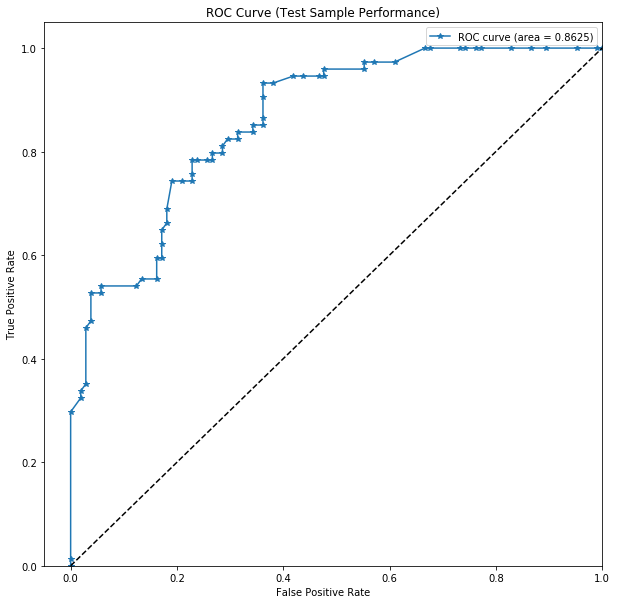

In [87]:
# Determine the false positive and true positive rates
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
 
# Calculate the AUC
roc_auc = auc(fpr,tpr)
print ('ROC AUC: %0.4f' % roc_auc)

#auc = roc_auc_score(y_test, y_pred_proba)
#print('AUC: %.4f' % auc)
 
# Plot of a ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,'*-',label='ROC curve (area = %0.4f)' % roc_auc)
#plt.plot(fpr,tpr,label='logit_auc= %0.4f'%roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Sample Performance)')
plt.legend(loc='best')
plt.show()

In [99]:
# Threshold adjustment: Create function to determine accuracy for each possible threshold level
scores = {}

# Store probability of survival for each passenger in a variable
# y_pred_proba = pipe.predict_proba(X_test)[:, 1]

for threshold in np.arange(0, 1, 0.01):
    # Creates binary classes based on probability and threshold
    y_bina = np.where(y_pred_proba>threshold, 1, 0)
    # Measures and stores accuracy
    accur = accuracy_score(y_test, y_bina)
    # Stores each threshold & its accuracy in a dictionary
    scores[threshold] = accur

In [100]:
# Threshold adjustment: Identify threshold with highest accuracy
max_threshold = max(scores, key=scores.get)
max_threshold

0.63

In [101]:
# Accuracy in test for best threshold
scores[max_threshold]

0.7821229050279329

# 10. Submissão da solução

Finalmente vamos utilizar o Dataset de teste fornecido pelo Kaggle. Agora é hora de utilizar nosso modelo treinado para fazer um predict sobre esses novos dados e submeter nossa resposta à avaliação da competição (ver no Kaggle o formato correto para submissão).

Caso o resultado obtido não seja satisfatório, voltamos para o passo 4 e tentamos novas ideias para a criação de features! Do contrário, concluímos nosso dessafio!

In [102]:
# Create submission DF and store PassengerID
submission = df_testanic[['PassengerId']]

In [103]:
# Apply all DF adjustments to test set

df_testanic['Title'] = df_testanic['Name'].str.extract(' ([A-Za-z]+)\.')
df_testanic['Title'] = df_testanic['Title'].replace(['Col','Major'], 'Mr')
df_testanic['Title'] = df_testanic['Title'].replace(['Ms', 'Lady', 'Mlle'], 'Miss')
df_testanic['Title'] = df_testanic['Title'].replace(['Countess', 'Mme'], 'Mrs')
#common_titles = ['Mr', 'Miss', 'Mrs']
df_testanic['Title'] = df_testanic['Title'].apply(lambda x: x if x in common_titles else 'Other')

unused_features_final = ['PassengerId','Name','Age','SibSp','Parch','Ticket','Cabin','Embarked']
df_testanic.drop(unused_features_final, axis=1, inplace=True)
df_testanic.head(3)

,Pclass,Sex,Fare,Title
0,3,male,7.8292,Mr
1,3,female,7.0000,Mrs
2,2,male,9.6875,Mr


In [104]:
# Missing values in test DF
df_testanic.isnull().sum()

Pclass    0
Sex       0
Fare      1
Title     0
dtype: int64

In [105]:
# New adjustment to account for missing value in test DF - must use Train data
fare_median = df_traintanic['Fare'].median(skipna=True)
df_testanic['Fare'] = df_testanic['Fare'].fillna(fare_median)

In [106]:
# Store probability of survival for each passenger in a variable
y_proba_surv_submission = pipe.predict_proba(df_testanic)[:, 1]

In [107]:
# Create binary classes based on probability and threshold
y_bin_submission = np.where(y_proba_surv_submission>max_threshold, 1, 0)

In [108]:
# Add Survived column to submission DF
submission['Survived'] = y_bin_submission

In [109]:
# Confirm size of submission DF
submission.shape

(418, 2)

In [113]:
# Export submission DF to csv
#submission.to_csv('Submission_jmod_01.csv', index=False)